# 🪄 image_classifier/prediction

In [1]:
import torch
import time
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from bluer_options import string
from bluer_objects import objects, file
from bluer_objects.metadata import get_from_object
from bluer_objects import storage
from bluer_sandbox import notebooks

from bluer_algo.host import signature
from bluer_algo import env
from bluer_algo.image_classifier.model.model import TinyCNN
from bluer_algo.image_classifier.dataset.dataset import ImageClassifierDataset
from bluer_algo.logger import logger

logger.info(f"{'.'.join(signature())},\nbuilt on {string.pretty_date()}")

/Users/kamangir/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
🪄  bluer_algo-4.161.1.bluer_ai-12.208.1.bluer_objects-6.218.1.bluer_options-5.144.1.torch-2.2.2.Python 3.12.9.Darwin 23.6.0..Jupyter-Notebook,
built on 02 July 2025, 09:58:49


In [2]:
prediction_object_name = objects.unique_object("image_classifier-prediction")

🌀  📂 image_classifier-prediction-2025-07-02-09-58-49-jj3k75


---

In [3]:
dataset_object_name = env.BLUER_ALGO_FRUITS_360_TEST_DATASET
# assert storage.download(dataset_object_name)

🪄  loading ImageClassifierDataset from fruits-365-dataset-2025-07-01-gn9up7 ...
🌀  loaded 99 row(s) of Unnamed: 0, filename, class_index, subset from /Users/kamangir/storage/abcli/fruits-365-dataset-2025-07-01-gn9up7/metadata.csv


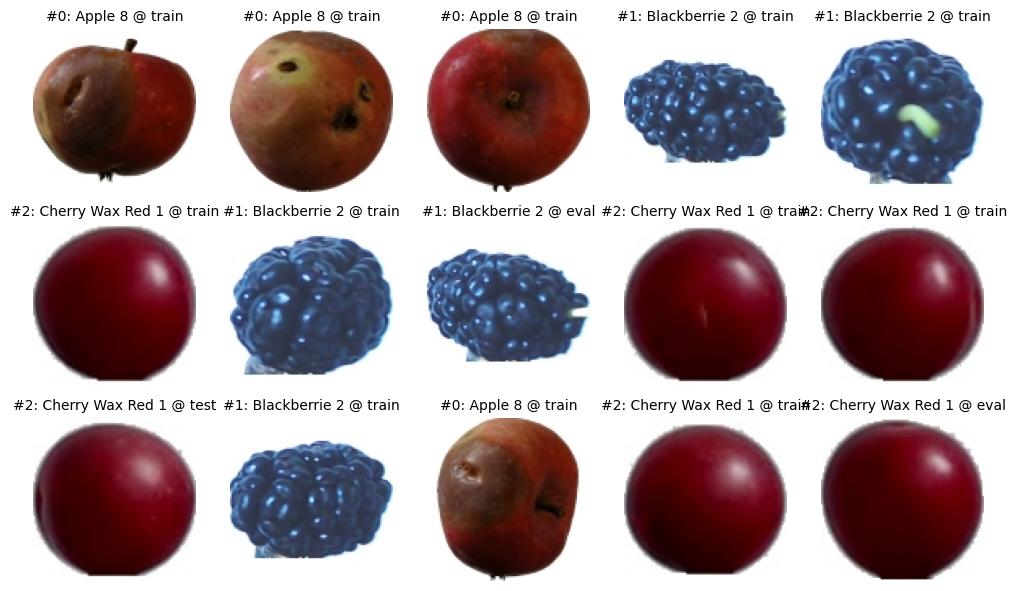

🌀  -> /Users/kamangir/storage/abcli/fruits-365-dataset-2025-07-01-gn9up7/grid.png
🪄  3 subset(s): train: 83 [%83.8], test: 5 [%5.1], eval: 11 [%11.1]
🪄  3 class(es): Apple 8: 33 [%33.3], Blackberrie 2: 33 [%33.3], Cherry Wax Red 1: 33 [%33.3]
🪄  shape: 100x100x3


In [4]:
success, dataset = ImageClassifierDataset.load(object_name=dataset_object_name)

---

In [5]:
model_object_name = env.BLUER_ALGO_FRUITS_360_TEST_MODEL
# assert storage.download(model_object_name)

In [6]:
model_filename = objects.path_of(
    object_name=model_object_name,
    filename="model.pth",
)

In [7]:
model_metadata = get_from_object(
    object_name=model_object_name,
    key="model",
)

class_count = model_metadata["dataset"]["class_count"]
logger.info(f"class_count: {class_count}")

🪄  class_count: 3


In [8]:
model = TinyCNN(class_count)
model.load_state_dict(torch.load(model_filename, map_location="cpu"))
model.eval()

TinyCNN(
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=64, out_features=3, bias=True)
  )
)

---

In [9]:
test_row = dataset.df[dataset.df["subset"] == "test"].sample(n=1)
logger.info(f"test_row: {test_row}")

success, image = file.load_image(
    objects.path_of(
        object_name=dataset_object_name,
        filename=test_row["filename"].values[0],
    )
)
assert success

class_index = test_row["class_index"].values[0]

🪄  test_row:     Unnamed: 0          filename  class_index subset
26          26  0-r0_161_100.jpg            0   test


In [10]:
# np_img is shape (H, W, 3) in RGB
assert isinstance(image, np.ndarray)
assert image.ndim == 3 and image.shape[2] == 3

elapsed_time = time.time()
# Convert to PIL for transforms
image_ = Image.fromarray(image.astype("uint8"))

# Apply same transform as training
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])
input_tensor = transform(image_).unsqueeze(0)  # Shape: [1, 3, 100, 100]

with torch.no_grad():
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()

elapsed_time = time.time() - elapsed_time

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


🪄  prediction: Apple 8 [#0]  (correct) - took 015 ms


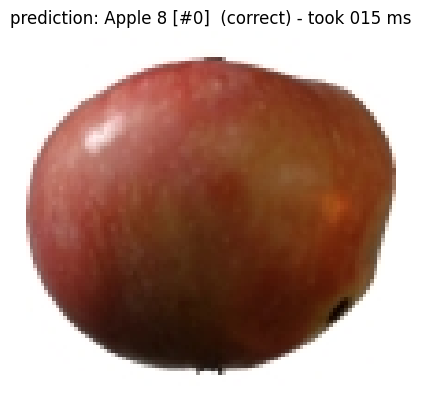

In [14]:
message = "prediction: {} [#{}] {}- took {}".format(
    dataset.dict_of_classes[predicted_class],
    predicted_class,
    " (correct) " if class_index == predicted_class else 
    "<> {} [#{}] ".format(
        dataset.dict_of_classes[class_index],
        class_index,
    ),
    string.pretty_duration(
        elapsed_time, 
        include_ms=True,
        short=True,
        ),
)
logger.info(message)

plt.imshow(image)
plt.title(message)
plt.axis("off")

assert file.save_fig(
    objects.path_of(
        object_name=prediction_object_name,
        filename="prediction.png",
    )
)

---

In [12]:
assert notebooks.upload(prediction_object_name)

100%|██████████| 2/2 [00:00<00:00,  3.71it/s]
🌀  ⏺️  image_classifier-prediction-2025-07-02-09-58-49-jj3k75 | 00001
🌀  ⬆️  /Users/kamangir/storage/abcli/image_classifier-prediction-2025-07-02-09-58-49-jj3k75/prediction.png
🌀  ⏹️  image_classifier-prediction-2025-07-02-09-58-49-jj3k75


In [15]:
print(f"@assets publish extensions=png,push {prediction_object_name}")

@assets publish extensions=png,push image_classifier-prediction-2025-07-02-09-58-49-jj3k75


In [13]:
# END